In [4]:
pip install psycopg2-binary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 2.1 MB/s eta 0:00:0000:0100:01m
Note: you may need to restart the kernel to use updated packages.


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from scipy import stats
import psycopg2
import warnings
import os
from datetime import datetime
import time

warnings.filterwarnings('ignore')

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")
np.random.seed(42)

print("="*80)
print("NYC TAXI FARE PREDICTION - ML REGRESSION PROJECT")
print("="*80)
print(f"Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

NYC TAXI FARE PREDICTION - ML REGRESSION PROJECT
Started at: 2025-11-12 22:55:24



In [2]:
print("\n" + "="*80)
print("CARGA DE DATOS DESDE POSTGRES")
print("="*80)

def cargar_datos_optimizado(anios=[2024], filas_por_anio=100000):
    PG_HOST = os.getenv("PG_HOST", "postgres")
    PG_PORT = os.getenv("PG_PORT", "5432")
    PG_DB = os.getenv("PG_DB", "nyc_taxi")
    PG_USER = os.getenv("PG_USER", "root")
    PG_PASS = os.getenv("PG_PASSWORD", "root")
    
    conn = psycopg2.connect(
        host=PG_HOST, port=PG_PORT, 
        database=PG_DB, user=PG_USER, password=PG_PASS
    )
    
    filas_por_mes = filas_por_anio // 12
    extra = filas_por_anio % 12
    
    anios_str = ",".join(str(a) for a in anios)
    
    query = f"""
    WITH base_filtrada AS (
        SELECT 
            pickup_datetime,
            pickup_hour,
            pickup_dow,
            month,
            year,
            pu_location_id,
            pu_zone,
            pu_borough,
            service_type,
            vendor_id,
            rate_code_id,
            payment_type,
            passenger_count,
            trip_distance,
            fare_amount,
            extra,
            mta_tax,
            improvement_surcharge,
            congestion_surcharge,
            airport_fee,
            total_amount,
            store_and_fwd_flag
        FROM analytics.obt_trips
        WHERE year IN ({anios_str})
          AND pickup_datetime IS NOT NULL
          AND trip_distance > 0 AND trip_distance < 100
          AND passenger_count BETWEEN 1 AND 6
          AND total_amount BETWEEN 2 AND 250
          AND fare_amount > 0
    ),
    con_bucket AS (
        SELECT *,
            NTILE(
                CASE 
                    WHEN month <= {extra} THEN {filas_por_mes + 1}
                    ELSE {filas_por_mes}
                END
            ) OVER (PARTITION BY year, month ORDER BY pickup_datetime) AS bucket
        FROM base_filtrada
    ),
    muestra AS (
        SELECT *,
            ROW_NUMBER() OVER (PARTITION BY year, month, bucket ORDER BY pickup_datetime) AS rn
        FROM con_bucket
    )
    SELECT 
        pickup_datetime, pickup_hour, pickup_dow, month, year,
        pu_location_id, pu_zone, pu_borough,
        service_type, vendor_id, rate_code_id, payment_type,
        passenger_count, trip_distance,
        fare_amount, extra, mta_tax, improvement_surcharge,
        congestion_surcharge, airport_fee, total_amount,
        store_and_fwd_flag
    FROM muestra
    WHERE rn = 1
    ORDER BY pickup_datetime;
    """
    
    print(f"Ejecutando query para años: {anios}")
    print(f"Target: ~{filas_por_anio:,} filas por año")
    
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    return df


datos = cargar_datos_optimizado(anios=[2024], filas_por_anio=100000)

print(f"\nDataset cargado: {datos.shape[0]:,} filas × {datos.shape[1]} columnas")
print(f"Memoria usada: {datos.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nDistribución por año-mes:")
dist_tiempo = datos.groupby(['year', 'month']).size().reset_index(name='registros')
print(dist_tiempo.to_string(index=False))


CARGA DE DATOS DESDE POSTGRES
Ejecutando query para años: [2024]
Target: ~100,000 filas por año

Dataset cargado: 100,000 filas × 22 columnas
Memoria usada: 38.52 MB

Distribución por año-mes:
 year  month  registros
 2024      1       8334
 2024      2       8334
 2024      3       8334
 2024      4       8334
 2024      5       8333
 2024      6       8333
 2024      7       8333
 2024      8       8333
 2024      9       8333
 2024     10       8333
 2024     11       8333
 2024     12       8333



ANÁLISIS EXPLORATORIO DE DATOS

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   pickup_datetime        100000 non-null  datetime64[ns]
 1   pickup_hour            100000 non-null  int64         
 2   pickup_dow             100000 non-null  int64         
 3   month                  100000 non-null  int64         
 4   year                   100000 non-null  int64         
 5   pu_location_id         100000 non-null  int64         
 6   pu_zone                100000 non-null  object        
 7   pu_borough             100000 non-null  object        
 8   service_type           100000 non-null  object        
 9   vendor_id              100000 non-null  int64         
 10  rate_code_id           100000 non-null  int64         
 11  payment_type           100000 non-null  int64  

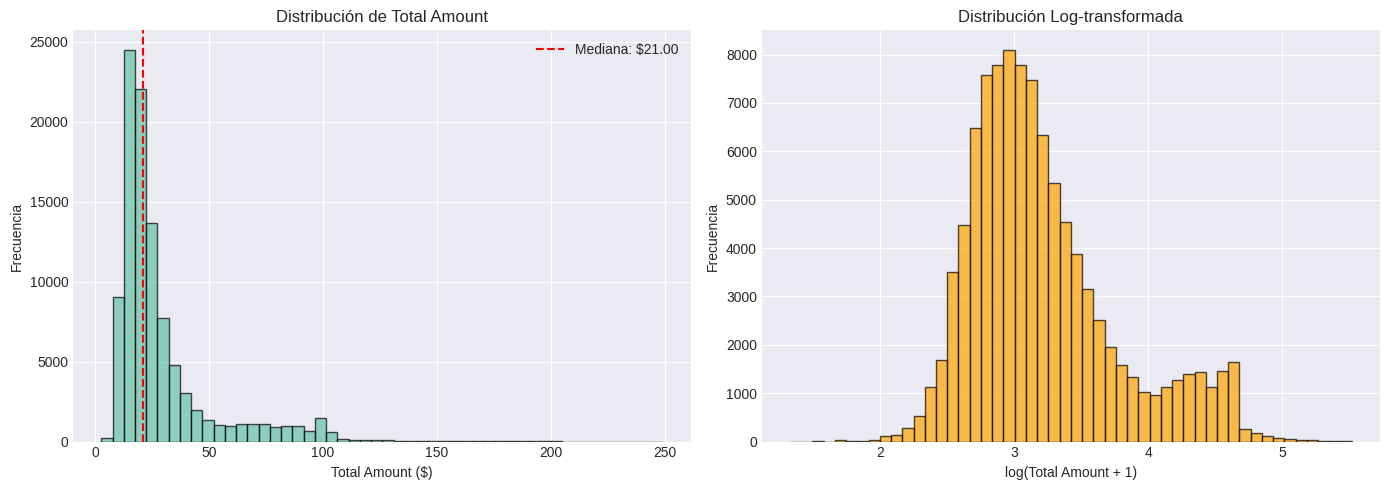


Valores nulos por columna:
airport_fee    1594
dtype: int64

 Cardinalidad de variables categóricas:
  service_type: 2 valores únicos
  vendor_id: 2 valores únicos
  rate_code_id: 6 valores únicos
  payment_type: 4 valores únicos
  pu_borough: 8 valores únicos
  pu_zone: 224 valores únicos


In [4]:
print("\n" + "="*80)
print("ANÁLISIS EXPLORATORIO DE DATOS")
print("="*80)

# Info básica
print("\nInformación del dataset:")
print(datos.info())

print("\nEstadísticas descriptivas del target:")
print(datos['total_amount'].describe())

# Distribución del target
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(datos['total_amount'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Total Amount ($)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Total Amount')
axes[0].axvline(datos['total_amount'].median(), color='red', linestyle='--', label=f'Mediana: ${datos["total_amount"].median():.2f}')
axes[0].legend()

axes[1].hist(np.log1p(datos['total_amount']), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('log(Total Amount + 1)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución Log-transformada')

plt.tight_layout()
plt.show()

# Valores nulos
print("\nValores nulos por columna:")
nulos = datos.isnull().sum()
nulos = nulos[nulos > 0].sort_values(ascending=False)
if len(nulos) > 0:
    print(nulos)
else:
    print("No hay valores nulos")

# Cardinalidad de categóricas
print("\n Cardinalidad de variables categóricas:")
categoricas = ['service_type', 'vendor_id', 'rate_code_id', 'payment_type', 
               'pu_borough', 'pu_zone']
for col in categoricas:
    if col in datos.columns:
        n_unique = datos[col].nunique()
        print(f"  {col}: {n_unique} valores únicos")

In [11]:
print("\n" + "="*80)
print("2. CONSTRUCCION DE FEATURES")
print("="*80)

def create_features(data):
    """Construye features derivadas para modelado"""
    
    df_proc = data.copy()
    
    # Asegurar tipos correctos
    df_proc['pickup_hour'] = df_proc['pickup_hour'].astype(int)
    df_proc['pickup_dow'] = df_proc['pickup_dow'].astype(int)
    df_proc['month'] = df_proc['month'].astype(int)
    df_proc['year'] = df_proc['year'].astype(int)
    
    # Flags temporales
    df_proc['is_rush_hour'] = (
        ((df_proc['pickup_hour'] >= 7) & (df_proc['pickup_hour'] <= 9)) | 
        ((df_proc['pickup_hour'] >= 17) & (df_proc['pickup_hour'] <= 19))
    )
    
    df_proc['is_weekend'] = df_proc['pickup_dow'].isin([5, 6])
    df_proc['is_night'] = (
        (df_proc['pickup_hour'] >= 20) | (df_proc['pickup_hour'] <= 5)
    )
    
    # Reducir cardinalidad de zonas
    top_zones = df_proc['pu_zone'].value_counts().head(20).index
    df_proc['pu_zone_processed'] = df_proc['pu_zone'].where(
        df_proc['pu_zone'].isin(top_zones), 'Other'
    )
    
    # Agregacion de componentes de tarifa base
    df_proc['base_fare_components'] = (
        df_proc['fare_amount'] + df_proc['extra'] + 
        df_proc['mta_tax'] + df_proc['improvement_surcharge']
    )
    
    # Definir conjuntos de features
    numeric_features = [
        'trip_distance', 'passenger_count', 'pickup_hour', 
        'base_fare_components', 'congestion_surcharge', 'airport_fee',
        'pickup_dow', 'month', 'year'
    ]
    
    categorical_features = [
        'service_type', 'vendor_id', 'rate_code_id', 
        'pu_borough', 'pu_zone_processed'
    ]
    
    binary_features = ['is_rush_hour', 'is_weekend', 'is_night']
    
    return df_proc, numeric_features, categorical_features, binary_features

df_processed, numeric_features, categorical_features, binary_features = create_features(datos)
print("Features construidas:")
print(f"Numericas: {numeric_features}")
print(f"Categoricas: {categorical_features}")
print(f"Binarias: {binary_features}")


2. CONSTRUCCION DE FEATURES
Features construidas:
Numericas: ['trip_distance', 'passenger_count', 'pickup_hour', 'base_fare_components', 'congestion_surcharge', 'airport_fee', 'pickup_dow', 'month', 'year']
Categoricas: ['service_type', 'vendor_id', 'rate_code_id', 'pu_borough', 'pu_zone_processed']
Binarias: ['is_rush_hour', 'is_weekend', 'is_night']


In [12]:
print("\n" + "="*80)
print("3. PREPARACION DE TIPOS DE DATOS")
print("="*80)

def prepare_features(data, numeric_features, categorical_features, binary_features):
    """Limpia y convierte tipos de datos"""
    
    df_prep = data.copy()
    
    # Numericas a float
    for col in numeric_features:
        if col in df_prep.columns:
            df_prep[col] = pd.to_numeric(df_prep[col], errors='coerce')
    
    # Binarias a int
    for col in binary_features:
        if col in df_prep.columns:
            df_prep[col] = df_prep[col].astype(int)
    
    # Categoricas a string
    for col in categorical_features:
        if col in df_prep.columns:
            df_prep[col] = df_prep[col].astype(str).fillna("missing")
    
    # Rellenar nulos
    df_prep = df_prep.fillna(0)
    
    return df_prep

df_prepared = prepare_features(df_processed, numeric_features, 
                               categorical_features, binary_features)
print("Preparacion completada.")


3. PREPARACION DE TIPOS DE DATOS
Preparacion completada.


In [13]:

print("\n" + "="*80)
print("4. SPLIT TEMPORAL DE DATOS")
print("="*80)

def temporal_split_by_years(data, train_years=None, val_years=None, test_years=None):
    """Divide datos por años completos"""
    
    df_sorted = data.sort_values('pickup_datetime').reset_index(drop=True)
    years_present = sorted(df_sorted['year'].astype(int).unique())

    if all(x is None for x in [train_years, val_years, test_years]):
        n = len(years_present)
        n_train = max(1, int(round(n * 0.70)))
        n_val = max(1, int(round(n * 0.15)))
        n_test = max(1, n - n_train - n_val)
        
        train_years = years_present[:n_train]
        val_years = years_present[n_train:n_train + n_val]
        test_years = years_present[n_train + n_val:]
    else:
        train_years = [] if train_years is None else sorted(set(map(int, train_years)))
        val_years = [] if val_years is None else sorted(set(map(int, val_years)))
        test_years = [] if test_years is None else sorted(set(map(int, test_years)))

    def y2s(year_val):
        if year_val in train_years: return 'train'
        if year_val in val_years: return 'validation'
        if year_val in test_years: return 'test'
        return 'ignore'

    df_sorted['split'] = df_sorted['year'].astype(int).map(y2s)
    df_sorted = df_sorted[df_sorted['split'] != 'ignore'].reset_index(drop=True)

    print("Distribucion del split:")
    print(df_sorted.groupby(['year', 'split']).size().to_frame('count').reset_index())
    
    print("\nRangos temporales:")
    for split_name in ['train', 'validation', 'test']:
        subset = df_sorted[df_sorted['split'] == split_name]
        if len(subset) > 0:
            print(f"{split_name}: {subset['pickup_datetime'].min()} -> {subset['pickup_datetime'].max()}")
        else:
            print(f"{split_name}: sin datos")
    
    return df_sorted, train_years, val_years, test_years

df_split = df_prepared.copy().sort_values('pickup_datetime').reset_index(drop=True)
df_split['split'] = 'train'
df_split.loc[df_split['month'] >= 9, 'split'] = 'validation'
df_split.loc[df_split['month'] >= 11, 'split'] = 'test'

print("\nDistribucion del split (por meses 2024):")
print(df_split.groupby(['month', 'split']).size().to_frame('count').reset_index())

# Verificar columnas
required_cols = set(numeric_features + categorical_features + binary_features)
missing = required_cols - set(df_split.columns)
assert not missing, f"Faltan columnas: {missing}"


4. SPLIT TEMPORAL DE DATOS

Distribucion del split (por meses 2024):
    month       split  count
0       1       train   8334
1       2       train   8334
2       3       train   8334
3       4       train   8334
4       5       train   8333
5       6       train   8333
6       7       train   8333
7       8       train   8333
8       9  validation   8333
9      10  validation   8333
10     11        test   8333
11     12        test   8333


In [14]:
print("\n" + "="*80)
print("5. CONSTRUCCION DE MATRICES")
print("="*80)

X = df_split[numeric_features + categorical_features + binary_features]
y = df_split['total_amount']

X_train = X[df_split['split'] == 'train']
y_train = y[df_split['split'] == 'train']

X_val = X[df_split['split'] == 'validation']
y_val = y[df_split['split'] == 'validation']

X_test = X[df_split['split'] == 'test']
y_test = y[df_split['split'] == 'test']

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Validation: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")


5. CONSTRUCCION DE MATRICES
Train: (66668, 17), (66668,)
Validation: (16666, 17), (16666,)
Test: (16666, 17), (16666,)


In [18]:
print("\n" + "="*80)
print("6. PREPROCESAMIENTO Y TRANSFORMACIONES")
print("="*80)

def create_preprocessor(numeric_features, categorical_features, binary_features):
    """Crea preprocesador unificado"""
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    binary_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('to_float', FunctionTransformer(lambda x: x.astype(float)))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            ('bin', binary_transformer, binary_features)
        ]
    )
    
    return preprocessor

preprocessor = create_preprocessor(numeric_features, categorical_features, binary_features)

X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

print(f"Datos preprocesados:")
print(f"X_train: {X_train_processed.shape}")
print(f"X_val: {X_val_processed.shape}")
print(f"X_test: {X_test_processed.shape}")

# Polynomial Features
print("\nAplicando Polynomial Features...")
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)

key_indices = [
    numeric_features.index('trip_distance'), 
    numeric_features.index('base_fare_components')
]

X_train_key = X_train_processed[:, key_indices]
X_val_key = X_val_processed[:, key_indices]
X_test_key = X_test_processed[:, key_indices]

X_train_poly = poly.fit_transform(X_train_key)
X_val_poly = poly.transform(X_val_key)
X_test_poly = poly.transform(X_test_key)

X_train_final = np.hstack([X_train_processed, X_train_poly])
X_val_final = np.hstack([X_val_processed, X_val_poly])
X_test_final = np.hstack([X_test_processed, X_test_poly])

print(f"Con Polynomial Features:")
print(f"Train: {X_train_final.shape}")
print(f"Val: {X_val_final.shape}")
print(f"Test: {X_test_final.shape}")


6. PREPROCESAMIENTO Y TRANSFORMACIONES
Datos preprocesados:
X_train: (66668, 49)
X_val: (16666, 49)
X_test: (16666, 49)

Aplicando Polynomial Features...
Con Polynomial Features:
Train: (66668, 52)
Val: (16666, 52)
Test: (16666, 52)


In [19]:
print("\n" + "="*80)
print("7. MODELOS FROM-SCRATCH")
print("="*80)

class SGDRegressorFromScratch:
    def __init__(self, learning_rate=0.01, max_iter=1000, tol=1e-4, alpha=0.0, random_state=42):
        self.learning_rate = float(learning_rate)
        self.max_iter = int(max_iter)
        self.tol = float(tol)
        self.alpha = float(alpha)
        self.random_state = int(random_state)
        self.loss_history = []
        
    def _initialize_weights(self, n_features):
        np.random.seed(self.random_state)
        self.weights = np.random.randn(n_features) * 0.01
        self.bias = 0.0
        
    def fit(self, X, y, verbose=False):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        m, n = X.shape
        self._initialize_weights(n)
        
        prev_loss = np.inf
        for i in range(self.max_iter):
            y_pred = X @ self.weights + self.bias
            error = y_pred - y
            loss = (0.5/m) * np.sum(error**2) + 0.5 * self.alpha * np.sum(self.weights**2)
            self.loss_history.append(loss)
            grad_w = (1.0/m) * (X.T @ error) + self.alpha * self.weights
            grad_b = (1.0/m) * np.sum(error)
            self.weights -= self.learning_rate * grad_w
            self.bias -= self.learning_rate * grad_b
            if abs(prev_loss - loss) < self.tol:
                if verbose:
                    print(f"Converged at iter {i}, loss={loss:.6f}")
                break
            prev_loss = loss
        return self
    
    def predict(self, X):
        return np.asarray(X, dtype=float) @ self.weights + self.bias

class RidgeRegressionFromScratch:
    def __init__(self, alpha=1.0, eps=1e-8):
        self.alpha = float(alpha)
        self.eps = float(eps)
        self.weights = None

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        n_features = X.shape[1]
        A = X.T @ X + (self.alpha + self.eps) * np.eye(n_features)
        b = X.T @ y
        self.weights = np.linalg.solve(A, b)
        return self

    def predict(self, X):
        return np.asarray(X, dtype=float) @ self.weights

class LassoRegressionFromScratch:
    def __init__(self, alpha=1.0, max_iter=1000, tol=1e-4):
        self.alpha = float(alpha)
        self.max_iter = int(max_iter)
        self.tol = float(tol)
        self.weights = None

    @staticmethod
    def _soft_threshold(z, gamma):
        if z > gamma: return z - gamma
        if z < -gamma: return z + gamma
        return 0.0

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        n, p = X.shape
        w = np.zeros(p, dtype=float)
        col_norm = (X**2).sum(axis=0) / n
        
        for it in range(self.max_iter):
            w_old = w.copy()
            y_pred = X @ w
            r = y - y_pred
            for j in range(p):
                rho = (X[:, j] * (r + X[:, j] * w[j])).sum() / n
                if col_norm[j] == 0:
                    w[j] = 0.0
                    continue
                w[j] = self._soft_threshold(rho, self.alpha) / col_norm[j]
                r = y - X @ w
            if np.max(np.abs(w - w_old)) < self.tol:
                break
        self.weights = w
        return self

    def predict(self, X):
        return np.asarray(X, dtype=float) @ self.weights

class ElasticNetFromScratch:
    def __init__(self, alpha=1.0, l1_ratio=0.5, max_iter=1000, tol=1e-4):
        self.alpha = float(alpha)
        self.l1_ratio = float(l1_ratio)
        self.max_iter = int(max_iter)
        self.tol = float(tol)
        self.weights = None

    @staticmethod
    def _soft_threshold(z, gamma):
        if z > gamma: return z - gamma
        if z < -gamma: return z + gamma
        return 0.0

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        n, p = X.shape
        w = np.zeros(p, dtype=float)
        l1 = self.alpha * self.l1_ratio
        l2 = self.alpha * (1.0 - self.l1_ratio)
        col_norm = (X**2).sum(axis=0) / n
        
        for it in range(self.max_iter):
            w_old = w.copy()
            y_pred = X @ w
            r = y - y_pred
            for j in range(p):
                rho = (X[:, j] * (r + X[:, j] * w[j])).sum() / n
                denom = col_norm[j] + l2
                if denom == 0:
                    w[j] = 0.0
                    continue
                w[j] = self._soft_threshold(rho, l1) / denom
                r = y - X @ w
            if np.max(np.abs(w - w_old)) < self.tol:
                break
        self.weights = w
        return self

    def predict(self, X):
        return np.asarray(X, dtype=float) @ self.weights

def evaluate_from_scratch_models(X_train, y_train, X_val, y_val):
    """Evalua modelos from-scratch"""
    
    results = {}
    models = {
        'SGD': SGDRegressorFromScratch(learning_rate=0.01, max_iter=1000),
        'Ridge': RidgeRegressionFromScratch(alpha=1.0),
        'Lasso': LassoRegressionFromScratch(alpha=0.1),
        'ElasticNet': ElasticNetFromScratch(alpha=0.1, l1_ratio=0.5)
    }
    
    for name, model in models.items():
        print(f"Entrenando {name}...")
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)
        
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
        val_mae = mean_absolute_error(y_val, y_pred_val)
        val_r2 = r2_score(y_val, y_pred_val)
        
        if hasattr(model, 'weights'):
            n_coef = np.sum(model.weights != 0)
        else:
            n_coef = X_train.shape[1]
        
        results[name] = {
            'train_rmse': train_rmse,
            'val_rmse': val_rmse,
            'val_mae': val_mae,
            'val_r2': val_r2,
            'train_time': train_time,
            'n_coefficients': n_coef
        }
        
        print(f"  Val RMSE: {val_rmse:.4f}, R2: {val_r2:.4f}, Time: {train_time:.2f}s")
    
    return results, models

print("Entrenando modelos from-scratch...")
from_scratch_results, from_scratch_models = evaluate_from_scratch_models(
    X_train_final, y_train.values, X_val_final, y_val.values
)


7. MODELOS FROM-SCRATCH
Entrenando modelos from-scratch...
Entrenando SGD...
  Val RMSE: 4.0226, R2: 0.9686, Time: 7.76s
Entrenando Ridge...
  Val RMSE: 3.4980, R2: 0.9763, Time: 0.07s
Entrenando Lasso...
  Val RMSE: 3.7632, R2: 0.9726, Time: 28.88s
Entrenando ElasticNet...
  Val RMSE: 4.3141, R2: 0.9639, Time: 13.03s


In [20]:
print("\n" + "="*80)
print("8. MODELOS SCIKIT-LEARN")
print("="*80)

def evaluate_sklearn_models(X_train, y_train, X_val, y_val):
    """Evalua modelos sklearn"""
    
    results = {}
    models = {
        'SGD': SGDRegressor(loss='squared_error', penalty='l2', 
                           alpha=0.01, max_iter=1000, random_state=42),
        'Ridge': Ridge(alpha=1.0, random_state=42),
        'Lasso': Lasso(alpha=0.1, random_state=42),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
    }
    
    for name, model in models.items():
        print(f"Entrenando {name} (sklearn)...")
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)
        
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
        val_mae = mean_absolute_error(y_val, y_pred_val)
        val_r2 = r2_score(y_val, y_pred_val)
        
        if hasattr(model, 'coef_'):
            n_coef = np.sum(model.coef_ != 0)
        else:
            n_coef = X_train.shape[1]
        
        results[name] = {
            'train_rmse': train_rmse,
            'val_rmse': val_rmse,
            'val_mae': val_mae,
            'val_r2': val_r2,
            'train_time': train_time,
            'n_coefficients': n_coef
        }
        
        print(f"  Val RMSE: {val_rmse:.4f}, R2: {val_r2:.4f}, Time: {train_time:.2f}s")
    
    return results, models

sklearn_results, sklearn_models = evaluate_sklearn_models(
    X_train_final, y_train.values, X_val_final, y_val.values
)


8. MODELOS SCIKIT-LEARN
Entrenando SGD (sklearn)...
  Val RMSE: 3.5654, R2: 0.9754, Time: 0.30s
Entrenando Ridge (sklearn)...
  Val RMSE: 3.4981, R2: 0.9763, Time: 0.07s
Entrenando Lasso (sklearn)...
  Val RMSE: 3.6524, R2: 0.9741, Time: 0.67s
Entrenando ElasticNet (sklearn)...
  Val RMSE: 3.8389, R2: 0.9714, Time: 0.67s


In [21]:
print("\n" + "="*80)
print("9. COMPARACION DE MODELOS")
print("="*80)

# Baselines
baseline_rows = []
for name, pred in [('Baseline (Mean)', np.full_like(y_val.values, y_train.values.mean())),
                   ('Baseline (Median)', np.full_like(y_val.values, np.median(y_train.values)))]:
    baseline_rows.append({
        'Model': name,
        'Val_RMSE': np.sqrt(mean_squared_error(y_val.values, pred)),
        'Val_MAE': mean_absolute_error(y_val.values, pred),
        'Val_R2': r2_score(y_val.values, pred),
        'Train_Time': 0.0,
        'N_Features': 0,
        'Type': 'Baseline'
    })

# Consolidar resultados
all_results = []
for name, res in from_scratch_results.items():
    all_results.append({
        'Model': f"{name} (From Scratch)",
        'Val_RMSE': res['val_rmse'],
        'Val_MAE': res['val_mae'],
        'Val_R2': res['val_r2'],
        'Train_Time': res['train_time'],
        'N_Features': res['n_coefficients'],
        'Type': 'From Scratch'
    })

for name, res in sklearn_results.items():
    all_results.append({
        'Model': f"{name} (Sklearn)",
        'Val_RMSE': res['val_rmse'],
        'Val_MAE': res['val_mae'],
        'Val_R2': res['val_r2'],
        'Train_Time': res['train_time'],
        'N_Features': res['n_coefficients'],
        'Type': 'Sklearn'
    })

comparison_df = pd.DataFrame(all_results + baseline_rows)
comparison_df = comparison_df.sort_values('Val_RMSE').reset_index(drop=True)

print("\nResultados en Validation:")
print(comparison_df.to_string(index=False))


9. COMPARACION DE MODELOS

Resultados en Validation:
                    Model  Val_RMSE   Val_MAE    Val_R2  Train_Time  N_Features         Type
     Ridge (From Scratch)  3.498006  2.125819  0.976285    0.070842          51 From Scratch
          Ridge (Sklearn)  3.498105  2.125861  0.976284    0.072708          51      Sklearn
            SGD (Sklearn)  3.565430  2.203293  0.975362    0.300530          51      Sklearn
          Lasso (Sklearn)  3.652418  2.119882  0.974145    0.673337           6      Sklearn
     Lasso (From Scratch)  3.763168  2.226197  0.972553   28.875671          11 From Scratch
     ElasticNet (Sklearn)  3.838866  2.204572  0.971438    0.670089          14      Sklearn
       SGD (From Scratch)  4.022581  2.387744  0.968639    7.760261          52 From Scratch
ElasticNet (From Scratch)  4.314101  2.589106  0.963928   13.025159          23 From Scratch
          Baseline (Mean) 22.744798 15.016903 -0.002647    0.000000           0     Baseline
        Baseline

In [22]:
# ============================================================================
# 10. GRID SEARCH Y TUNING DE HIPERPARAMETROS
# ============================================================================

print("\n" + "="*80)
print("10. GRID SEARCH Y OPTIMIZACION DE HIPERPARAMETROS")
print("="*80)

# Grid Search para modelos FROM-SCRATCH
import itertools

def grid_search_from_scratch(X_tr, y_tr, X_va, y_va):
    """Grid search manual para modelos from-scratch"""
    search_space = {
        'SGD': {
            'learning_rate': [1e-2, 5e-3], 
            'max_iter': [1000, 3000], 
            'alpha': [0.0, 1e-3, 1e-2]
        },
        'Ridge': {'alpha': [0.01, 0.1, 1.0, 10.0]},
        'Lasso': {'alpha': [0.01, 0.1, 0.5]},
        'ElasticNet': {'alpha': [0.01, 0.1, 0.5], 'l1_ratio': [0.2, 0.5, 0.8]}
    }
    
    best = {}
    
    for name, grid in search_space.items():
        print(f"\nOptimizando {name} from-scratch...")
        keys, values = zip(*grid.items())
        best[name] = {'rmse': np.inf, 'params': None}
        
        for combo in itertools.product(*values):
            cfg = dict(zip(keys, combo))
            
            if name == 'SGD':
                model = SGDRegressorFromScratch(
                    learning_rate=cfg['learning_rate'], 
                    max_iter=cfg['max_iter'], 
                    alpha=cfg['alpha']
                )
            elif name == 'Ridge':
                model = RidgeRegressionFromScratch(alpha=cfg['alpha'])
            elif name == 'Lasso':
                model = LassoRegressionFromScratch(alpha=cfg['alpha'])
            else:
                model = ElasticNetFromScratch(
                    alpha=cfg['alpha'], 
                    l1_ratio=cfg['l1_ratio']
                )
            
            t0 = time.time()
            model.fit(X_tr, y_tr)
            t1 = time.time()
            
            y_pred_val = model.predict(X_va)
            rmse = np.sqrt(mean_squared_error(y_va, y_pred_val))
            
            if rmse < best[name]['rmse']:
                best[name] = {
                    'rmse': rmse, 
                    'params': cfg, 
                    'train_time': t1 - t0, 
                    'model': model
                }
        
        print(f"  Mejor {name}: RMSE={best[name]['rmse']:.4f}, params={best[name]['params']}")
    
    return best

print("Ejecutando Grid Search para modelos FROM-SCRATCH...")
best_fs = grid_search_from_scratch(X_train_final, y_train.values, X_val_final, y_val.values)

# Grid Search para modelos SKLEARN
def grid_search_sklearn(X_tr, y_tr, X_va, y_va):
    """Grid search con GridSearchCV de sklearn"""
    models = {
        'SGD': SGDRegressor(loss='squared_error', penalty='l2', random_state=42),
        'Ridge': Ridge(random_state=42),
        'Lasso': Lasso(random_state=42),
        'ElasticNet': ElasticNet(random_state=42)
    }
    
    param_grids = {
        'SGD': {'alpha': [0.001, 0.01], 'max_iter': [1000, 3000]},
        'Ridge': {'alpha': [0.01, 0.1, 1.0, 10.0]},
        'Lasso': {'alpha': [0.01, 0.1, 0.5]},
        'ElasticNet': {'alpha': [0.01, 0.1, 0.5], 'l1_ratio': [0.2, 0.5, 0.8]}
    }
    
    best = {}
    
    for name, base in models.items():
        print(f"\nOptimizando {name} sklearn...")
        gs = GridSearchCV(
            base, 
            param_grids[name], 
            scoring='neg_root_mean_squared_error', 
            cv=3, 
            n_jobs=-1
        )
        
        t0 = time.time()
        gs.fit(X_tr, y_tr)
        t1 = time.time()
        
        y_pred_val = gs.best_estimator_.predict(X_va)
        rmse = np.sqrt(mean_squared_error(y_va, y_pred_val))
        
        best[name] = {
            'rmse': rmse, 
            'params': gs.best_params_, 
            'train_time': t1 - t0, 
            'model': gs.best_estimator_
        }
        
        print(f"  Mejor {name}: RMSE={rmse:.4f}, params={gs.best_params_}")
    
    return best

print("\nEjecutando Grid Search para modelos SKLEARN...")
best_sk = grid_search_sklearn(X_train_final, y_train.values, X_val_final, y_val.values)


10. GRID SEARCH Y OPTIMIZACION DE HIPERPARAMETROS
Ejecutando Grid Search para modelos FROM-SCRATCH...

Optimizando SGD from-scratch...
  Mejor SGD: RMSE=3.6927, params={'learning_rate': 0.01, 'max_iter': 3000, 'alpha': 0.0}

Optimizando Ridge from-scratch...
  Mejor Ridge: RMSE=3.4960, params={'alpha': 10.0}

Optimizando Lasso from-scratch...
  Mejor Lasso: RMSE=3.5006, params={'alpha': 0.01}

Optimizando ElasticNet from-scratch...
  Mejor ElasticNet: RMSE=3.5448, params={'alpha': 0.01, 'l1_ratio': 0.8}

Ejecutando Grid Search para modelos SKLEARN...

Optimizando SGD sklearn...
  Mejor SGD: RMSE=3.5373, params={'alpha': 0.001, 'max_iter': 1000}

Optimizando Ridge sklearn...
  Mejor Ridge: RMSE=3.4959, params={'alpha': 10.0}

Optimizando Lasso sklearn...
  Mejor Lasso: RMSE=3.4929, params={'alpha': 0.01}

Optimizando ElasticNet sklearn...
  Mejor ElasticNet: RMSE=3.5041, params={'alpha': 0.01, 'l1_ratio': 0.8}


In [23]:
print("\n" + "="*80)
print("11. EVALUACION EN TEST - MEJORES MODELOS")
print("="*80)

def evaluate_on_test(models_dict, X_te, y_te, label_suffix):
    """Evalua modelos en test set"""
    rows = []
    for name, info in models_dict.items():
        mdl = info['model']
        y_pred = mdl.predict(X_te)
        rows.append({
            'Model': f"{name} ({label_suffix})",
            'Test_RMSE': np.sqrt(mean_squared_error(y_te, y_pred)),
            'Test_MAE': mean_absolute_error(y_te, y_pred),
            'Test_R2': r2_score(y_te, y_pred),
            'Params': info['params']
        })
    return pd.DataFrame(rows)

def refit_best_and_eval(best_fs, best_sk, X_tr, y_tr, X_va, y_va, X_te, y_te):
    """Reentrena mejores modelos con Train+Val y evalua en Test"""
    # Concatenar train + val
    X_tv = np.vstack([X_tr, X_va])
    y_tv = np.concatenate([y_tr, y_va])
    
    # Reentrenar todos los mejores modelos
    print("Reentrenando mejores modelos con Train+Val...")
    for d in [best_fs, best_sk]:
        for k, info in d.items():
            print(f"  Reentrenando {k}...")
            info['model'].fit(X_tv, y_tv)
    
    # Evaluar en test
    df_fs = evaluate_on_test(best_fs, X_te, y_te, 'From Scratch')
    df_sk = evaluate_on_test(best_sk, X_te, y_te, 'Sklearn')
    
    return pd.concat([df_fs, df_sk], ignore_index=True)

test_all = refit_best_and_eval(
    best_fs, best_sk, 
    X_train_final, y_train.values, 
    X_val_final, y_val.values, 
    X_test_final, y_test.values
)

# Añadir baselines en TEST
base_rows = []
for name, const_val in [('Baseline (Mean)', y_train.values.mean()), 
                        ('Baseline (Median)', np.median(y_train.values))]:
    y_pred = np.full_like(y_test.values, const_val, dtype=float)
    base_rows.append({
        'Model': name,
        'Test_RMSE': np.sqrt(mean_squared_error(y_test.values, y_pred)),
        'Test_MAE': mean_absolute_error(y_test.values, y_pred),
        'Test_R2': r2_score(y_test.values, y_pred),
        'Params': {}
    })

test_all = pd.concat([pd.DataFrame(base_rows), test_all], ignore_index=True)

print("\nRESULTADOS EN TEST (re-entrenados con Train+Val):")
print(test_all.sort_values('Test_RMSE').reset_index(drop=True).round(4))


11. EVALUACION EN TEST - MEJORES MODELOS
Reentrenando mejores modelos con Train+Val...
  Reentrenando SGD...
  Reentrenando Ridge...
  Reentrenando Lasso...
  Reentrenando ElasticNet...
  Reentrenando SGD...
  Reentrenando Ridge...
  Reentrenando Lasso...
  Reentrenando ElasticNet...

RESULTADOS EN TEST (re-entrenados con Train+Val):
                       Model  Test_RMSE  Test_MAE  Test_R2  \
0       Ridge (From Scratch)     3.2877    2.0743   0.9775   
1            Ridge (Sklearn)     3.2893    2.0756   0.9774   
2            Lasso (Sklearn)     3.3012    2.0669   0.9773   
3       Lasso (From Scratch)     3.3074    2.0676   0.9772   
4       ElasticNet (Sklearn)     3.3208    2.0700   0.9770   
5  ElasticNet (From Scratch)     3.3526    2.0850   0.9766   
6              SGD (Sklearn)     3.3556    2.0944   0.9765   
7         SGD (From Scratch)     3.5042    2.1407   0.9744   
8            Baseline (Mean)    21.9082   14.5627  -0.0004   
9          Baseline (Median)    23.4141   1

In [25]:
print("\n" + "="*80)
print("12. SELECCIÓN Y ANÁLISIS DEL MEJOR MODELO")
print("="*80)

# Seleccionar mejor modelo (menor RMSE en test)
df_candidates = test_all[~test_all['Model'].str.contains('Baseline')]

best_index = df_candidates['Test_RMSE'].idxmin()
best_row = df_candidates.loc[best_index]

best_model_name = best_row['Model']
best_test_rmse = best_row['Test_RMSE']

print(f"MODELO GANADOR: {best_model_name}")
print(f"Test RMSE: {best_test_rmse:.4f}")
print(f"Test MAE: {best_row['Test_MAE']:.4f}")
print(f"Test R2: {best_row['Test_R2']:.4f}")
print(f"Hiperparámetros: {best_row['Params']}")

# Obtener el modelo ganador real
if 'From Scratch' in best_model_name:
    model_key = best_model_name.replace(' (From Scratch)', '')
    best_model_final = best_fs[model_key]['model']
else:
    model_key = best_model_name.replace(' (Sklearn)', '')
    best_model_final = best_sk[model_key]['model']



12. SELECCIÓN Y ANÁLISIS DEL MEJOR MODELO
MODELO GANADOR: Ridge (From Scratch)
Test RMSE: 3.2877
Test MAE: 2.0743
Test R2: 0.9775
Hiperparámetros: {'alpha': 10.0}



13. DIAGNOSTICO DE ERRORES Y RESIDUALES


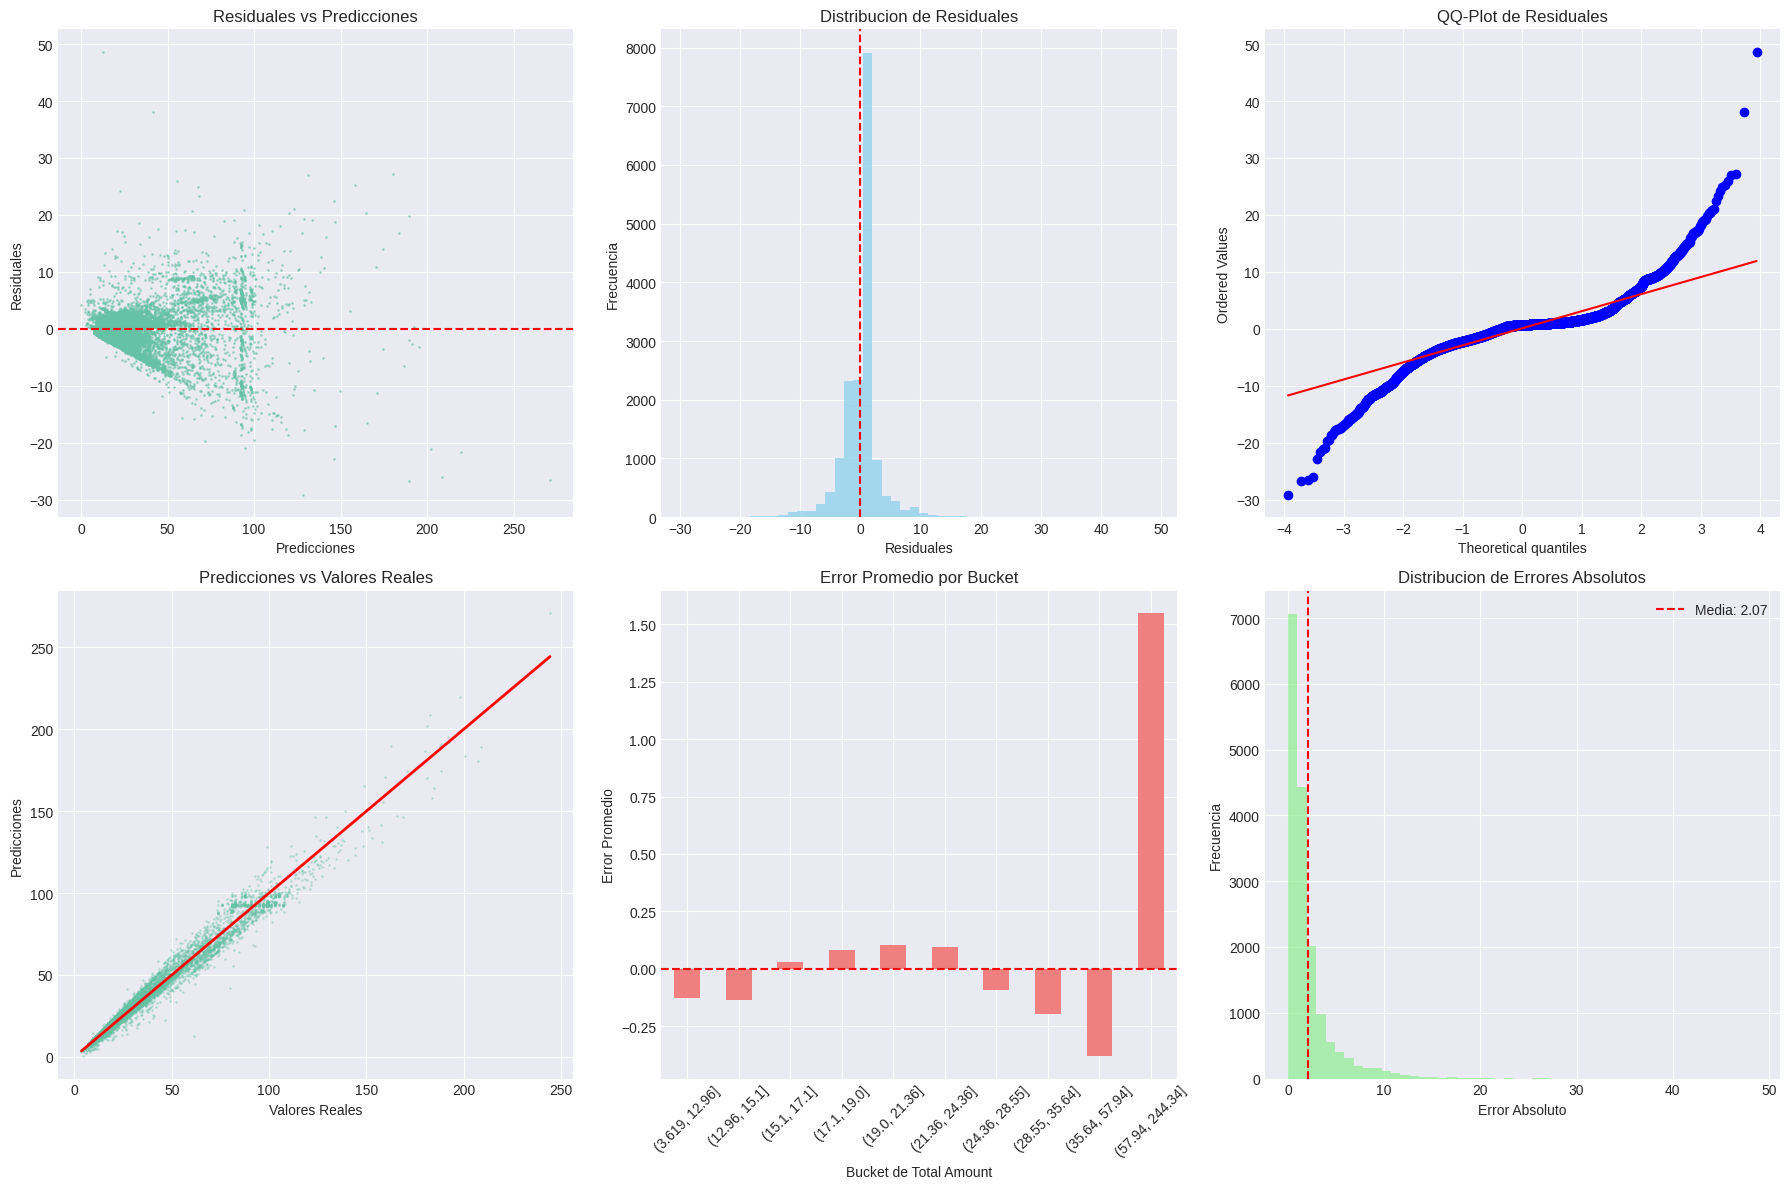


ESTADISTICAS DE ERROR:
Error Absoluto Medio (MAE): 2.0743
Desviacion Estandar: 3.2864
Error Absoluto Mediano: 1.1346
Porcentaje errores < $2: 69.77%
Porcentaje errores < $5: 90.63%

ERRORES POR BUCKET:
                residual              
                    mean     std count
amount_bucket                         
(3.619, 12.96]   -0.1296  1.2270  1710
(12.96, 15.1]    -0.1369  1.3077  1632
(15.1, 17.1]      0.0313  1.3885  1686
(17.1, 19.0]      0.0825  1.5402  1642
(19.0, 21.36]     0.1048  1.7039  1668
(21.36, 24.36]    0.0956  1.7455  1675
(24.36, 28.55]   -0.0944  2.2384  1660
(28.55, 35.64]   -0.1961  2.7245  1674
(35.64, 57.94]   -0.3820  4.2304  1653
(57.94, 244.34]   1.5501  7.8645  1666


In [28]:
print("\n" + "="*80)
print("13. DIAGNOSTICO DE ERRORES Y RESIDUALES")
print("="*80)

def error_analysis(best_model, X_test, y_test, model_name):
    """Analisis detallado de errores"""
    
    y_pred_test = best_model.predict(X_test)
    residuals = y_test - y_pred_test
    
    # Graficos de diagnostico
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Residuales vs Predicciones
    axes[0, 0].scatter(y_pred_test, residuals, alpha=0.5, s=1)
    axes[0, 0].axhline(y=0, color='red', linestyle='--')
    axes[0, 0].set_xlabel('Predicciones')
    axes[0, 0].set_ylabel('Residuales')
    axes[0, 0].set_title('Residuales vs Predicciones')
    
    # 2. Distribucion de residuales
    axes[0, 1].hist(residuals, bins=50, alpha=0.7, color='skyblue')
    axes[0, 1].axvline(x=0, color='red', linestyle='--')
    axes[0, 1].set_xlabel('Residuales')
    axes[0, 1].set_ylabel('Frecuencia')
    axes[0, 1].set_title('Distribucion de Residuales')
    
    # 3. QQ-Plot
    stats.probplot(residuals, dist="norm", plot=axes[0, 2])
    axes[0, 2].set_title('QQ-Plot de Residuales')
    
    # 4. Predicciones vs Valores Reales
    axes[1, 0].scatter(y_test, y_pred_test, alpha=0.3, s=1)
    axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                    'red', lw=2)
    axes[1, 0].set_xlabel('Valores Reales')
    axes[1, 0].set_ylabel('Predicciones')
    axes[1, 0].set_title('Predicciones vs Valores Reales')
    
    # 5. Errores por buckets
    error_df = pd.DataFrame({
        'actual': y_test,
        'predicted': y_pred_test,
        'residual': residuals
    })
    
    error_df['amount_bucket'] = pd.qcut(error_df['actual'], q=10, duplicates='drop')
    bucket_errors = error_df.groupby('amount_bucket').agg({
        'residual': ['mean', 'std', 'count']
    }).round(4)
    
    bucket_errors['residual']['mean'].plot(kind='bar', ax=axes[1, 1], color='lightcoral')
    axes[1, 1].axhline(y=0, color='red', linestyle='--')
    axes[1, 1].set_xlabel('Bucket de Total Amount')
    axes[1, 1].set_ylabel('Error Promedio')
    axes[1, 1].set_title('Error Promedio por Bucket')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    # 6. Distribucion de errores absolutos
    absolute_errors = np.abs(residuals)
    axes[1, 2].hist(absolute_errors, bins=50, alpha=0.7, color='lightgreen')
    axes[1, 2].axvline(x=absolute_errors.mean(), color='red', linestyle='--', 
                       label=f'Media: {absolute_errors.mean():.2f}')
    axes[1, 2].set_xlabel('Error Absoluto')
    axes[1, 2].set_ylabel('Frecuencia')
    axes[1, 2].set_title('Distribucion de Errores Absolutos')
    axes[1, 2].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Metricas de error adicionales
    print("\nESTADISTICAS DE ERROR:")
    print(f"Error Absoluto Medio (MAE): {np.mean(absolute_errors):.4f}")
    print(f"Desviacion Estandar: {np.std(residuals):.4f}")
    print(f"Error Absoluto Mediano: {np.median(absolute_errors):.4f}")
    print(f"Porcentaje errores < $2: {(absolute_errors < 2).mean()*100:.2f}%")
    print(f"Porcentaje errores < $5: {(absolute_errors < 5).mean()*100:.2f}%")
    
    print("\nERRORES POR BUCKET:")
    print(bucket_errors)
    
    return error_df, bucket_errors

error_df, bucket_errors = error_analysis(
    best_model_final, X_test_final, y_test.values, best_model_name
)

In [29]:

print("\n" + "="*80)
print("14. CONCLUSIONES FINALES Y RECOMENDACIONES")
print("="*80)

def generate_conclusions(test_results, best_model_name, error_df):
    """Genera conclusiones finales del proyecto"""
    
    best_row = test_results[test_results['Model'] == best_model_name].iloc[0]
    baseline_mean = test_results[test_results['Model'] == 'Baseline (Mean)'].iloc[0]
    
    print(f"\nMODELO FINAL SELECCIONADO:")
    print(f"  Nombre: {best_model_name}")
    print(f"  RMSE Test: ${best_row['Test_RMSE']:.2f}")
    print(f"  MAE Test: ${best_row['Test_MAE']:.2f}")
    print(f"  R2 Test: {best_row['Test_R2']:.4f}")
    
    print(f"\nMEJORA vs BASELINE:")
    improvement = ((baseline_mean['Test_RMSE'] - best_row['Test_RMSE']) / 
                  baseline_mean['Test_RMSE'] * 100)
    print(f"  Reduccion de RMSE: {improvement:.1f}%")
    print(f"  RMSE Baseline (Media): ${baseline_mean['Test_RMSE']:.2f}")
    
    print(f"\nCOMPARACION FROM-SCRATCH vs SKLEARN:")
    fs_models = test_results[test_results['Model'].str.contains('From Scratch')]
    sk_models = test_results[test_results['Model'].str.contains('Sklearn')]
    
    print(f"  RMSE Promedio From-Scratch: ${fs_models['Test_RMSE'].mean():.2f}")
    print(f"  RMSE Promedio Sklearn: ${sk_models['Test_RMSE'].mean():.2f}")
    
    print(f"\nDISTRIBUCION DE ERRORES:")
    abs_errors = np.abs(error_df['residual'])
    print(f"  50% de viajes: error < ${np.percentile(abs_errors, 50):.2f}")
    print(f"  80% de viajes: error < ${np.percentile(abs_errors, 80):.2f}")
    print(f"  95% de viajes: error < ${np.percentile(abs_errors, 95):.2f}")
    
    print(f"\nRECOMENDACIONES OPERATIVAS:")
    print(f"  1. Precision promedio: +/- ${abs_errors.mean():.2f}")
    print(f"  2. Casos de buen rendimiento: {(abs_errors < 3).mean()*100:.1f}% con error < $3")
    print(f"  3. Re-entrenamiento sugerido: mensual con datos nuevos")
    print(f"  4. Monitorear: viajes de alta tarifa (>$50) tienen mayor error")

generate_conclusions(test_all, best_model_name, error_df)

print("\n" + "="*80)
print("ANALISIS COMPLETADO")
print("="*80)


14. CONCLUSIONES FINALES Y RECOMENDACIONES

MODELO FINAL SELECCIONADO:
  Nombre: Ridge (From Scratch)
  RMSE Test: $3.29
  MAE Test: $2.07
  R2 Test: 0.9775

MEJORA vs BASELINE:
  Reduccion de RMSE: 85.0%
  RMSE Baseline (Media): $21.91

COMPARACION FROM-SCRATCH vs SKLEARN:
  RMSE Promedio From-Scratch: $3.36
  RMSE Promedio Sklearn: $3.32

DISTRIBUCION DE ERRORES:
  50% de viajes: error < $1.13
  80% de viajes: error < $2.80
  95% de viajes: error < $7.12

RECOMENDACIONES OPERATIVAS:
  1. Precision promedio: +/- $2.07
  2. Casos de buen rendimiento: 81.7% con error < $3
  3. Re-entrenamiento sugerido: mensual con datos nuevos
  4. Monitorear: viajes de alta tarifa (>$50) tienen mayor error

ANALISIS COMPLETADO
